##### Imports

In [ ]:
from scripts.clustering import *
from scripts.plotting import * 

Progress tracking

In [11]:
# track progress
tqdm.pandas()

### Datasets of embeddings
- **cls**: 357 dim -> 90% EV
- **mean**: 288 dim -> 90% EV

- we decide to use **cls** since it gives us better toxic profiles
    - for better, in our case study, we intend clusters with more sensible groupings of specific toxic traits
    - this is a qualitative aspect evaluated by visualizing the real dataset-wise standardized toxicities characterizing each cluster

In [12]:
# define embeddings' extraction strategy and dimensionality to use
pooling = "cls"
n_comp = 357

In [13]:
# real embeddings
real_embs = np.load(f"../final_data/pandora/embeddings_tox/{pooling}/PANDORA_test_embs_{n_comp}.npy")

print(f"Shape real embeddings: {real_embs.shape}")

Shape real embeddings: (50000, 358)


In [14]:
# simulated embeddings
bef_embs = np.load(f"../final_data/simulator/exante/before_mod/embeddings_tox/{pooling}/SIMULATOR_exante_bef_embs_{n_comp}.npy")
ofsa_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_ofsa_embs_{n_comp}.npy")
neut_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_neut_embs_{n_comp}.npy")
emp_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_emp_embs_{n_comp}.npy")
pres_embs = np.load(f"../final_data/simulator/exante/after_mod/embeddings_tox/{pooling}/SIMULATOR_exante_pres_embs_{n_comp}.npy")

print(f"Shape before mod embeddings: {bef_embs.shape}")
print(f"Shape ofsa embeddings: {ofsa_embs.shape}")
print(f"Shape neutral embeddings: {neut_embs.shape}")
print(f"Shape empathizing embeddings: {emp_embs.shape}")
print(f"Shape prescriptive embeddings: {pres_embs.shape}")

Shape before mod embeddings: (3131, 358)
Shape ofsa embeddings: (2579, 358)
Shape neutral embeddings: (2620, 358)
Shape empathizing embeddings: (2624, 358)
Shape prescriptive embeddings: (2599, 358)


##### Labels

In [15]:
# real
real_labels = np.full((real_embs.shape[0], 1), "Real")
# simulated
bef_labels = np.full((bef_embs.shape[0], 1), "Unmoderated")
ofsa_labels = np.full((ofsa_embs.shape[0], 1), "One-Size-Fits-All")
neut_labels = np.full((neut_embs.shape[0], 1), "Neutral")
emp_labels = np.full((emp_embs.shape[0], 1), "Empathizing")
pres_labels = np.full((pres_embs.shape[0], 1), "Prescriptive")

##### Keep only embeddings (remove comment IDs)

In [16]:
real_embs = real_embs[:, 1:]
bef_embs = bef_embs[:, 1:]
ofsa_embs = ofsa_embs[:, 1:]
neut_embs = neut_embs[:, 1:]
emp_embs = emp_embs[:, 1:]
pres_embs = pres_embs[:, 1:]

## Clustering embeddings
- the main idea is to perform clustering on the real and all simulated embeddings separately
    - to find toxic profiles
- then to find a mapping between the real and simulated toxic profiles
    - characterize the clusters based on the dominant toxic traits
- analyze the clusters in terms of their transparent features
    - toxicity, personalities, affective/emotional features, linguistics/readability...
- this is done looking at real vs before mod, and then before vs after mod

##### Real vs simulated with t-SNE
- real vs before moderation
- before vs after each type of moderation

In [8]:
n_components = 2

In [ ]:
# t-SNE on real and before mod embeddings for visualization
df_tsne_real_bef = apply_tsne(real_embs, real_labels, bef_embs, bef_labels, n_components = n_components)
# t-SNE on before and after mod embeddings for visualization
df_tsne_bef_ofsa = apply_tsne(bef_embs, bef_labels, ofsa_embs, ofsa_labels, n_components = n_components)
df_tsne_bef_neut = apply_tsne(bef_embs, bef_labels, neut_embs, neut_labels, n_components = n_components)
df_tsne_bef_emp = apply_tsne(bef_embs, bef_labels, emp_embs, emp_labels, n_components = n_components)
df_tsne_bef_pres = apply_tsne(bef_embs, bef_labels, pres_embs, pres_labels, n_components = n_components)

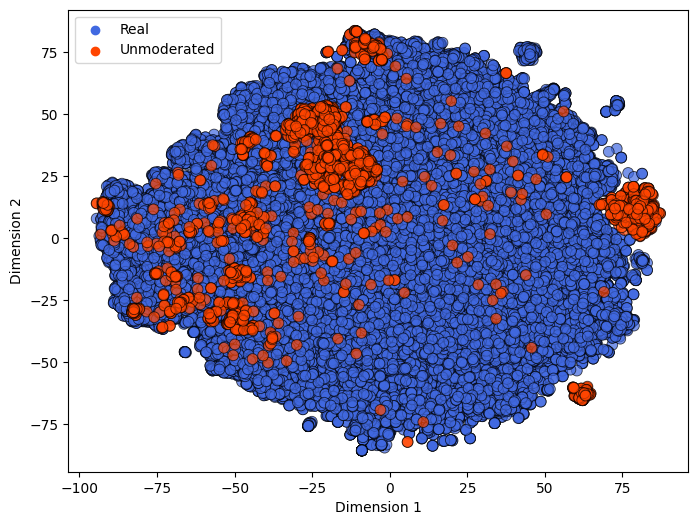

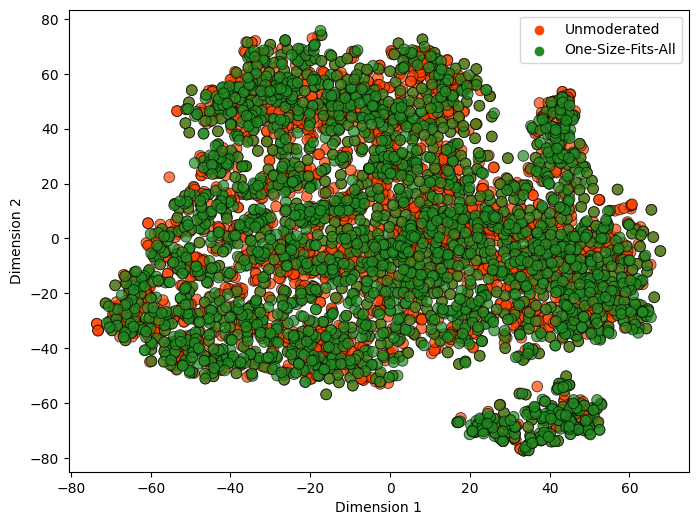

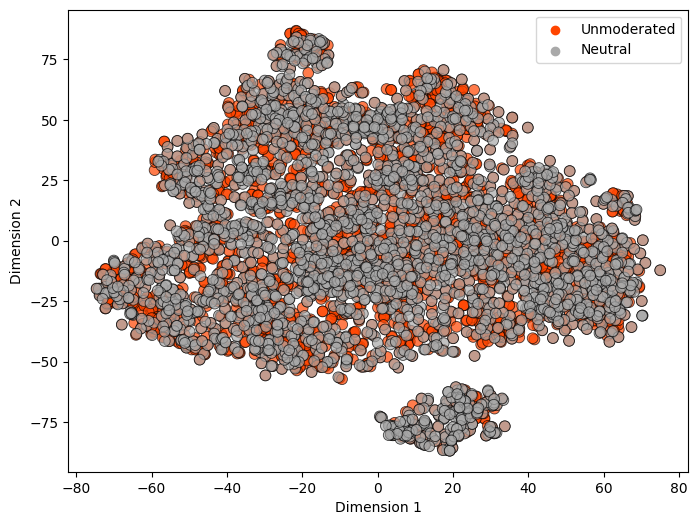

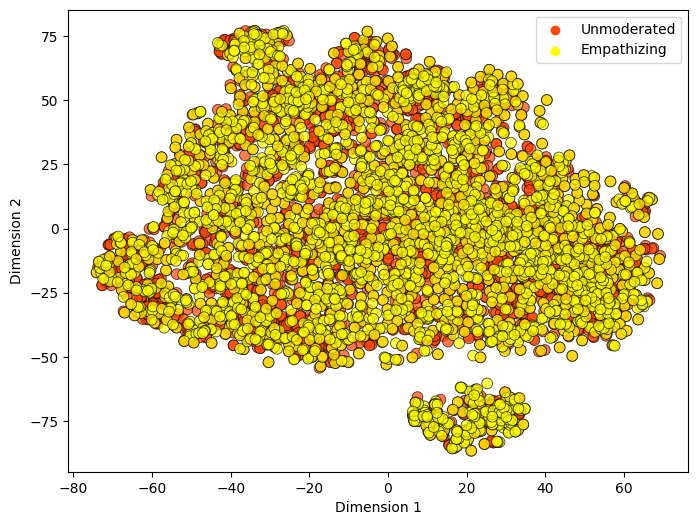

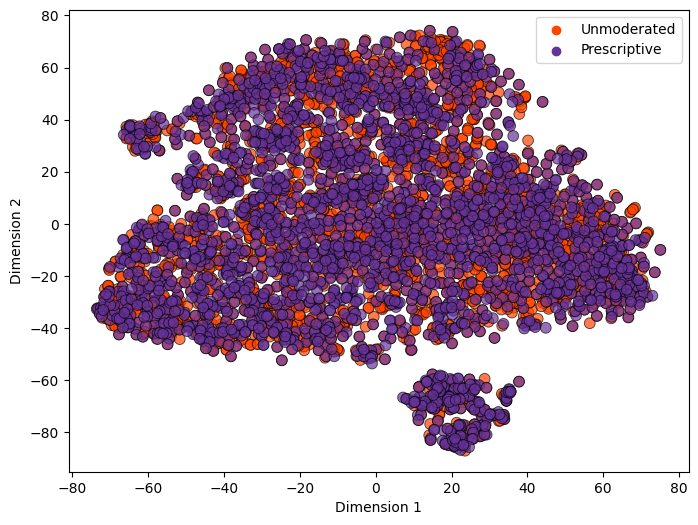

In [ ]:
# plotting embeddings
dfs_tsne = [df_tsne_real_bef, df_tsne_bef_ofsa, df_tsne_bef_neut, df_tsne_bef_emp, df_tsne_bef_pres]
colors = [["royalblue", "orangered"], ["orangered", "forestgreen"], ["orangered", "darkgray"], ["orangered", "yellow"], ["orangered", "rebeccapurple"]]

for d, c in zip(dfs_tsne, colors):
    if n_components == 2:
        plot_tsne(d, col = "label", colors = c)
    else:
        plot_tsne_3d(d, col = "label", colors = c)

### Clustering
- we use K-Means
    - tried hierarchical and DBSCAN, both result in sigleton clusters
- find optimal number of clusters based exclusively on real data, since it represents the real-world comments distribution
- then use the optimal k to perform clustering on both real and simulated data
- we use the euclidean distance
    - cosine distance matrix requires too much memory, tried some other libraries but didn't work properly

##### K-Means

Optimal clusters (elbow method)

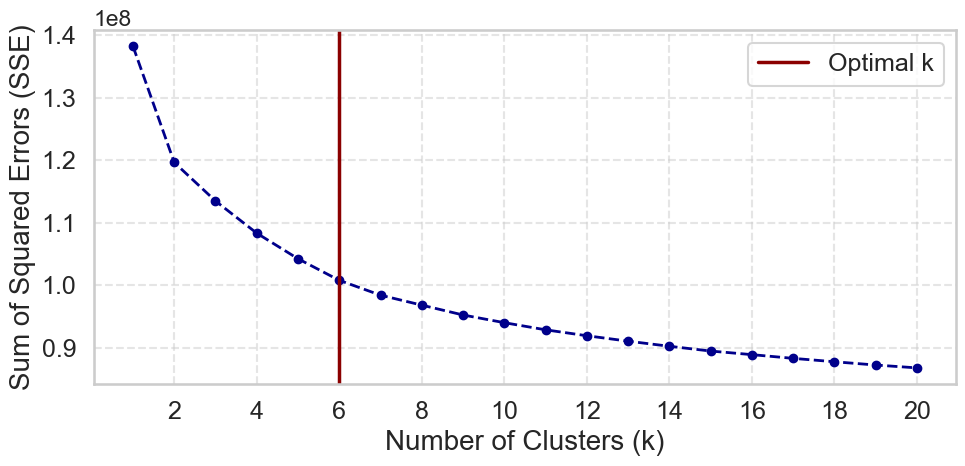

Optimal number of clusters: 6


In [22]:
# number of clusters to eval
k_range = range(1, 21)
# return optimal number of clusters with the elbow method
opt_k = optimal_k(real_embs, k_range, l2_norm = False)

print(f"Optimal number of clusters: {opt_k}")

Use optimal k for clustering on the embeddings for each dataset separately

In [ ]:
# K-Means with optimal number of clusters
# real
kmeans_real = KMeans(n_clusters = opt_k, random_state = SEED)
# simulated
kmeans_bef = KMeans(n_clusters = opt_k, random_state = SEED)
kmeans_ofsa = KMeans(n_clusters = opt_k, random_state = SEED)
kmeans_neut = KMeans(n_clusters = opt_k, random_state = SEED)
kmeans_emp = KMeans(n_clusters = opt_k, random_state = SEED)
kmeans_pres = KMeans(n_clusters = opt_k, random_state = SEED)

In [ ]:
# clustering on real embeddings
real_clusters = kmeans_real.fit_predict(real_embs)

# clustering on simulated embeddings
bef_clusters = kmeans_bef.fit_predict(bef_embs)
ofsa_clusters = kmeans_ofsa.fit_predict(ofsa_embs)
neut_clusters = kmeans_neut.fit_predict(neut_embs)
emp_clusters = kmeans_emp.fit_predict(emp_embs)
pres_clusters = kmeans_pres.fit_predict(pres_embs)

In [ ]:
print("Clusterings' composition:\n")
print(f"real:\n{dict(Counter(real_clusters))}")
print(f"before mod:\n{dict(Counter(bef_clusters))}")
print(f"ofsa:\n{dict(Counter(ofsa_clusters))}")
print(f"neutral:\n{dict(Counter(neut_clusters))}")
print(f"empathizing:\n{dict(Counter(emp_clusters))}")
print(f"prescriptive:\n{dict(Counter(pres_clusters))}")

Clusterings' composition:

real:
{2: 22310, 3: 10744, 0: 5459, 5: 3952, 1: 4631, 4: 2904}
before mod:
{0: 749, 1: 897, 4: 359, 5: 356, 3: 528, 2: 242}
ofsa:
{2: 968, 1: 561, 4: 334, 0: 323, 3: 183, 5: 210}
neutral:
{0: 833, 1: 872, 3: 333, 5: 116, 4: 300, 2: 166}
empathizing:
{1: 1016, 0: 735, 5: 374, 3: 176, 2: 93, 4: 230}
prescriptive:
{0: 828, 1: 700, 4: 383, 5: 307, 3: 185, 2: 196}


##### Silhouette scores

In [ ]:
ss_real = silhouette_score(real_embs, real_clusters)
ss_bef = silhouette_score(bef_embs, bef_clusters)
ss_ofsa = silhouette_score(ofsa_embs, ofsa_clusters)
ss_neut = silhouette_score(neut_embs, neut_clusters)
ss_emp = silhouette_score(emp_embs, emp_clusters)
ss_pres = silhouette_score(pres_embs, pres_clusters)

print("Silhouette scores:\n")
print(f"real: {ss_real}")
print(f"before mod: {ss_bef}")
print(f"ofsa: {ss_ofsa}")
print(f"neutral: {ss_neut}")
print(f"empathizing: {ss_emp}")
print(f"prescriptive: {ss_pres}")

Silhouette scores:

real: 0.06912221875573742
before mod: 0.08772024051298952
ofsa: 0.12366107769709823
neutral: 0.10565083996986567
empathizing: 0.1274266624938734
prescriptive: 0.11399930070133989


##### Clusters with t-SNE

In [ ]:
# real
df_tsne_real_clust = apply_tsne(real_embs, real_clusters, n_components = 2)
# simulated
df_tsne_bef_clust = apply_tsne(bef_embs, bef_clusters, n_components = 2)
df_tsne_ofsa_clust = apply_tsne(ofsa_embs, ofsa_clusters, n_components = 2)
df_tsne_neut_clust = apply_tsne(neut_embs, neut_clusters, n_components = 2)
df_tsne_emp_clust = apply_tsne(emp_embs, emp_clusters, n_components = 2)
df_tsne_pres_clust = apply_tsne(pres_embs, pres_clusters, n_components = 2)

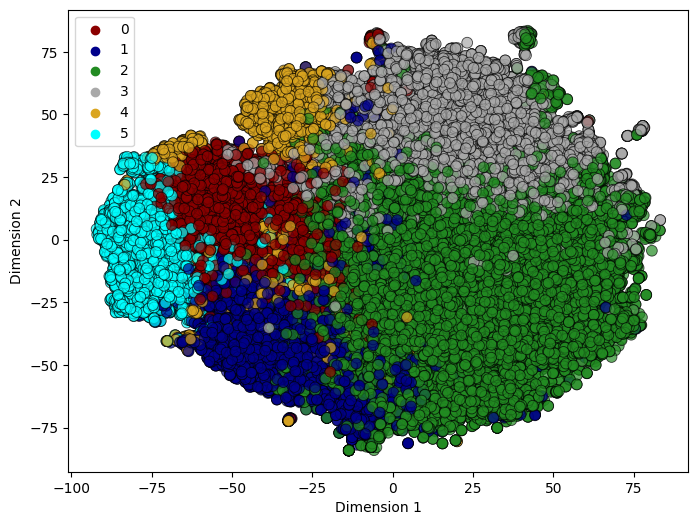

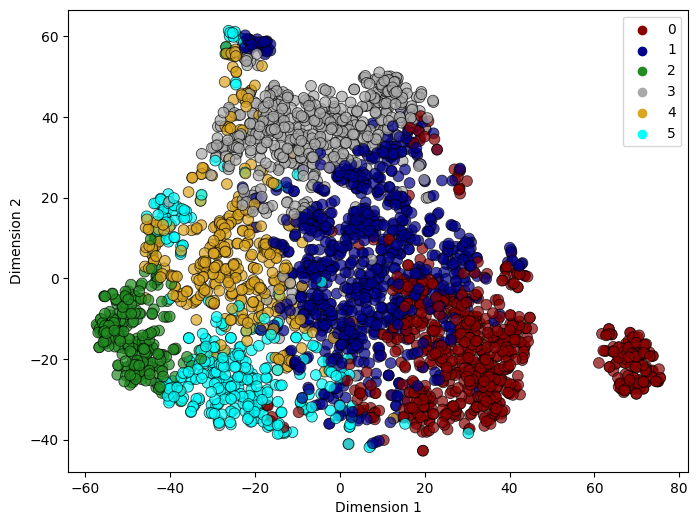

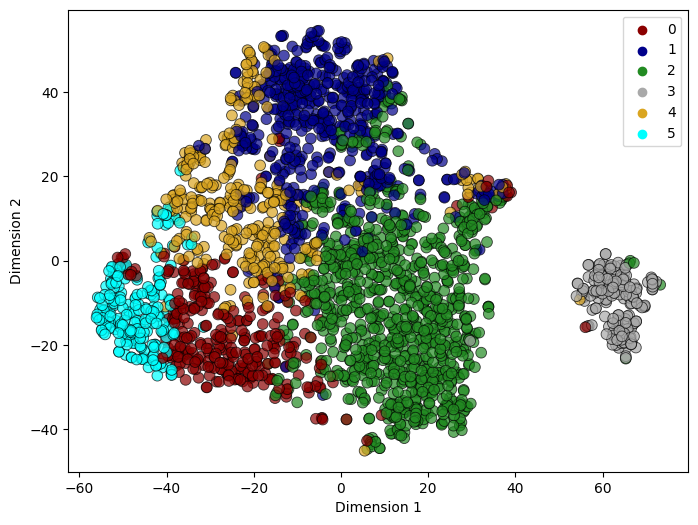

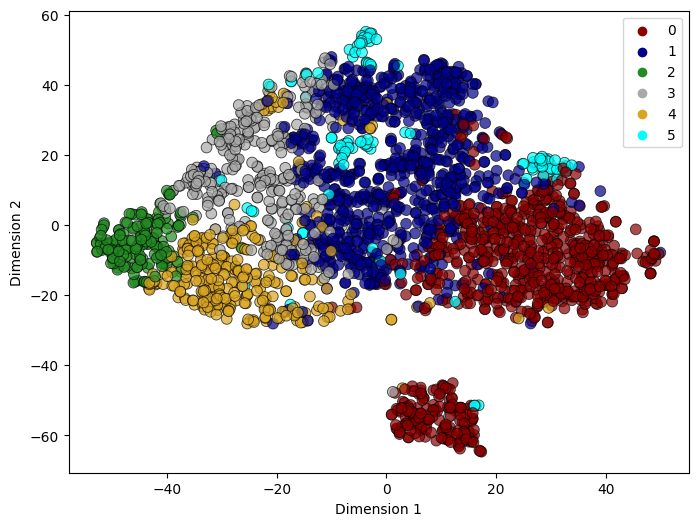

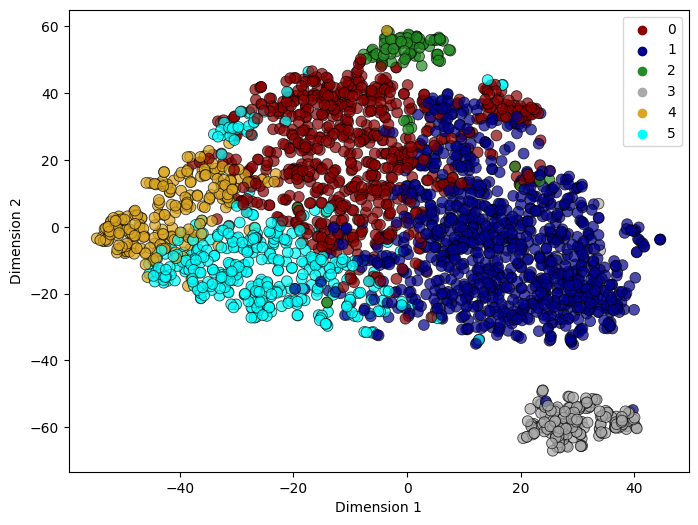

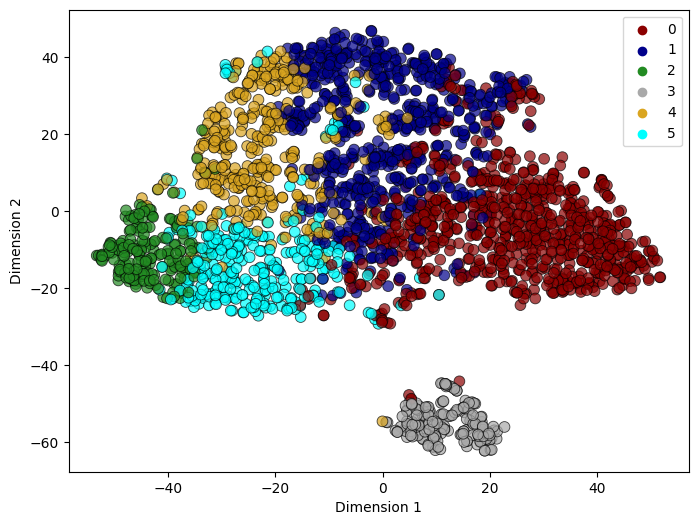

In [ ]:
# plotting embeddings
dfs_tsne = [df_tsne_real_clust, df_tsne_bef_clust, df_tsne_ofsa_clust, df_tsne_neut_clust, df_tsne_emp_clust, df_tsne_pres_clust]

for d in dfs_tsne:
    plot_tsne(d, col = "label", colors = ["darkred", "darkblue", "forestgreen", "darkgray", "goldenrod", "cyan"])

### Clusters annotation
- we annotate the datasets of transparent features with the clusters labels
- and export the annotated datasets for further analyses

In [ ]:
# real dataset
df_real = pd.read_csv("../final_data/pandora/PANDORA_test.csv", encoding = "utf-8")
# cluster labels
df_real["cluster"] = real_clusters

In [ ]:
# before moderation dataset
df_bef = pd.read_csv("../final_data/simulator/exante/before_mod/SIMULATOR_exante_bef.csv", encoding = "utf-8")
# cluster labels
df_bef["cluster"] = bef_clusters

In [ ]:
# after moderation datasets
df_ofsa = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_ofsa.csv", encoding = "utf-8")
df_neut = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_neut.csv", encoding = "utf-8")
df_emp = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_emp.csv", encoding = "utf-8")
df_pres = pd.read_csv("../final_data/simulator/exante/after_mod/SIMULATOR_exante_pres.csv", encoding = "utf-8")

# cluster labels
df_ofsa["cluster"] = ofsa_clusters
df_neut["cluster"] = neut_clusters
df_emp["cluster"] = emp_clusters
df_pres["cluster"] = pres_clusters

### Real clusters' toxic composition

In [ ]:
# toxic traits
tox_feat = ["obscene", "threat", "insult", "identity_attack"]

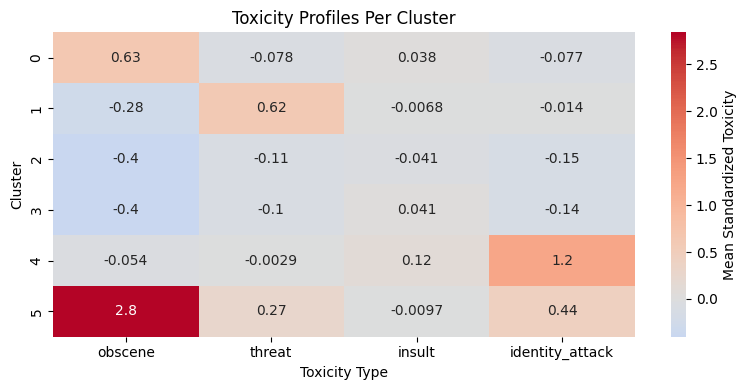

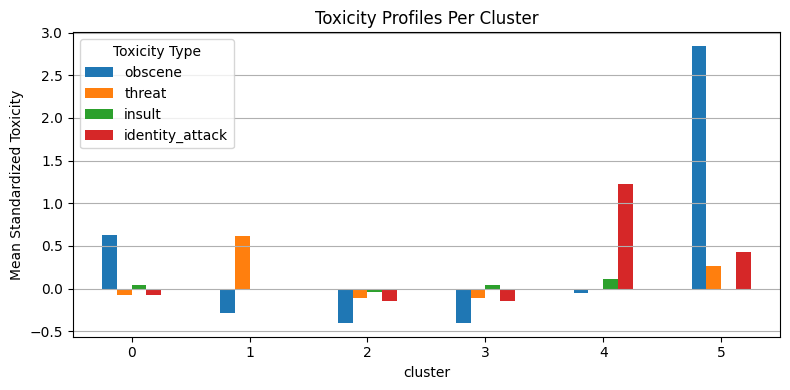

In [ ]:
plot_std_centroids(df_real, tox_feat, "cluster")

##### Datasets for real vs before moderation analyses

In [ ]:
df_real.to_csv("../data_real_before/PANDORA_test.csv", index = False, encoding = "utf-8")
df_bef.to_csv("../data_real_before/SIMULATOR_exante_bef.csv", index = False, encoding = "utf-8")

##### Datasets for before vs after moderation analyses

In [ ]:
df_bef.to_csv("../data_before_after/SIMULATOR_exante_bef.csv", index = False, encoding = "utf-8")
df_ofsa.to_csv("../data_before_after/SIMULATOR_exante_ofsa.csv", index = False, encoding = "utf-8")
df_neut.to_csv("../data_before_after/SIMULATOR_exante_neut.csv", index = False, encoding = "utf-8")
df_emp.to_csv("../data_before_after/SIMULATOR_exante_emp.csv", index = False, encoding = "utf-8")
df_pres.to_csv("../data_before_after/SIMULATOR_exante_pres.csv", index = False, encoding = "utf-8")